In [1]:
%load_ext lab_black
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import *
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy

# from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.types import Date
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
# Inspector to know the columns
inspector = inspect(engine)
pprint(inspector.get_columns("Measurement"))

[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'date',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'prcp',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'tobs',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]


In [9]:
# Check how the dates are
engine.execute("SELECT date FROM Measurement LIMIT 5").fetchall()

[('2010-01-01',),
 ('2010-01-02',),
 ('2010-01-03',),
 ('2010-01-04',),
 ('2010-01-06',)]

# Exploratory Climate Analysis

In [10]:
# Query to retrieve the last 12 months
date_max = session.query(func.max(Measurement.date)).first()[0]
date_max = dt.datetime.strptime(date_max, "%Y-%m-%d").date()
year_before = date_max - timedelta(365)

print(f"The analysis will be from {year_before} to {date_max}.")

The analysis will be from 2016-08-23 to 2017-08-23.


In [29]:
# Query to retrieve precipitation for the latest year
prcp = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= year_before)
    .order_by(Measurement.date)
    .all()
)

# Load the query results into a Pandas DataFrame, set the index to the date column, and  Sort the DataFrame values by `date`.
prcp_df = (pd.DataFrame(prcp)).set_index("date").sort_index(ascending=True)

# Save the query results
prcp_df

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


<Figure size 432x288 with 0 Axes>

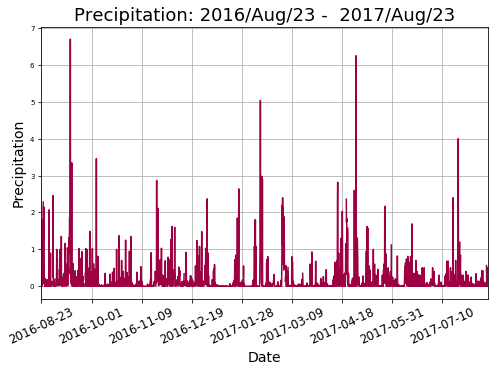

In [47]:
# Plot the results using the DataFrame `plot` method.
plt.gcf().subplots_adjust(bottom=0.15)
prcp_df.plot(
    y="prcp",
    kind="line",
    grid=True,
    fontsize=12,
    rot=25,
    legend=False,
    colormap="Spectral",
    use_index=True,
    figsize=(8, 5),
)
plt.title("Precipitation: 2016/Aug/23 -  2017/Aug/23", size=18)
plt.xlabel("Date", size=14)
plt.ylabel("Precipitation", size=14)
plt.yticks(size=7)
plt.savefig("Output/precipitation_amounts.png")
plt.show()

In [31]:
# Use Pandas to print the summary statistics for the precipitation data.
prcp_df.describe().rename({"prcp": "Precipitation"}, axis=1)

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [32]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Station.name).count()

print(f"The total number of Stations is {count_stations}.")

The total number of Stations is 9.


In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

print(active_station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?

most_active = active_station[0][0]

mim_max_avg_temp = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active)
    .all()
)

print(f"The station {most_active} has the highest number of observations.")
print(
    f"The minimum temperature at station {most_active} is {mim_max_avg_temp[0][0]}, the maximun is {mim_max_avg_temp[0][1]} and the average is {mim_max_avg_temp[0][2]}."
)

The station USC00519281 has the highest number of observations.
The minimum temperature at station USC00519281 is 54.0, the maximun is 85.0 and the average is 71.66378066378067.


In [35]:
mim_max_avg_temp = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active)
    .all()
)

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram.

most_active_tobs = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active)
    .filter(Measurement.date >= year_before)
    .order_by(Measurement.date.desc())
    .all()
)

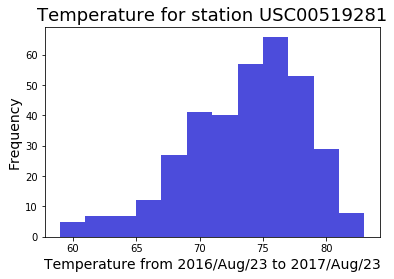

<Figure size 576x360 with 0 Axes>

In [37]:
x = [x[0] for x in most_active_tobs]
plt.hist(x, bins=12, color="mediumblue", alpha=0.7)
plt.title(f"Temperature for station {most_active}", size=18)
plt.xlabel("Temperature from 2016/Aug/23 to 2017/Aug/23", size=14)
plt.ylabel("Frequency", size=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.figure(figsize=(8, 5))
plt.savefig("Output/temperature_results_hist.png")
plt.show()

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )

In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.

trip_start = dt.date(2017, 3, 23)
trip_end = dt.date(2017, 4, 2)

trip_min = calc_temps(trip_start, trip_end)[0][0]
trip_avg = calc_temps(trip_start, trip_end)[0][1]
trip_max = calc_temps(trip_start, trip_end)[0][2]

print(
    f" From {trip_start} to {trip_end} the minimum, maximum and average temperature was {trip_min}, {trip_avg} and {trip_max} respectively."
)

 From 2017-03-23 to 2017-04-02 the minimum, maximum and average temperature was 68.0, 74.65671641791045 and 80.0 respectively.


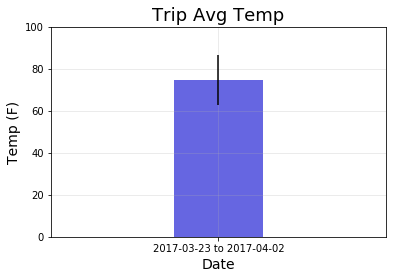

<Figure size 576x360 with 0 Axes>

In [40]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip = f"{trip_start} to {trip_end}"
yerr = trip_max - trip_min

plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(trip, trip_avg, yerr=yerr, color="mediumblue", alpha=0.6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title("Trip Avg Temp", size=18)
plt.ylabel("Temp (F)", size=14)
plt.xlabel("Date", size=14)
plt.grid(alpha=0.3)
plt.figure(figsize=(8, 5))
plt.savefig("Output/trip_abg_temp.png")
plt.show()

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query = (
    session.query(
        Station.station,
        Station.name,
        func.sum(Measurement.prcp),
        Station.latitude,
        Station.longitude,
        Station.elevation,
    )
    .filter(Station.station == Measurement.station)
    .filter(Measurement.date >= trip_start)
    .filter(Measurement.date <= trip_end)
    .group_by(Station.station)
    .order_by(func.sum(Measurement.prcp).desc())
    .all()
)

# Convert query object to data frame
trip_rain_db = (pd.DataFrame(np.array(query))).rename(
    columns={
        0: "Station",
        1: "Name",
        2: "PRCP",
        3: "Latitude",
        4: "Longitude",
        5: "Elevation",
    }
)
trip_rain_db

,Station,Name,PRCP,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.63,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.33,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.84,21.4234,-157.8015,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.6,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.21,21.5213,-157.8374,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [42]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(
            *sel
        )  # (*sel) means that the list produced in the Args (sel) will be wrapped up in a tuple.
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )

In [43]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`
trip_start = dt.date(2017, 3, 23)
trip_end = dt.date(2017, 4, 2)
trip_lenght = trip_end - trip_start

# Use the start and end date to create a range of dates
trip_range = pd.date_range(start=trip_start, end=trip_end)

# Stip off the year and save a list of %m-%d strings
trip_range = trip_range.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normals = [daily_normals(date) for date in trip_range]

In [44]:
# Extract normals into a list of lists
trip_normals = [np.array(normal[0]) for normal in trip_normals]

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_db = pd.DataFrame(trip_normals)

# Add date column
trip_normals_db["Date"] = trip_range

# Set index and rename columns
trip_normals_db = trip_normals_db.set_index("Date")
trip_normals_db = trip_normals_db.rename(columns={0: "T Min", 1: "T Avg", 2: "T Max"})

trip_normals_db

,T Min,T Avg,T Max
Date,,,
03-23,63.0,70.796296,78.0
03-24,62.0,71.500000,77.0
03-25,63.0,71.500000,78.0
03-26,64.0,71.380000,80.0
03-27,63.0,71.538462,80.0
03-28,59.0,71.517857,82.0
03-29,58.0,71.357143,77.0
03-30,62.0,72.175439,79.0
03-31,61.0,71.875000,79.0


<Figure size 432x288 with 0 Axes>

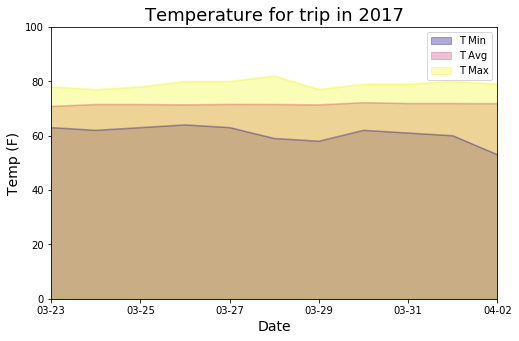

In [46]:
# Plot the daily normals as an area plot with `stacked=False`
plt.gcf().subplots_adjust(bottom=0.15)
trip_normals_db.plot.area(
    stacked=False, colormap="plasma", alpha=0.333, rot=0, figsize=(8, 5)
)
plt.title(f"Temperature for trip in 2017", size=18)
plt.ylabel("Temp (F)", size=14)
plt.xlabel("Date", size=14)
plt.ylim(0, 100)
plt.savefig("Output/trip_temperature_results_area.png")
plt.show()